# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='Reacher.app')
#env = UnityEnvironment(file_name='Reacher_20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Training agent

In [6]:
agent = Agent(
    state_size=state_size,
    action_size=action_size,
    random_seed=2,
)

In [7]:
def ddpg(
    n_agents,
    n_episodes=1000,
    max_t=300,
    print_every=100,
    smoothing_length=100,
    goal_score=30,
):
    scores_deque = deque(maxlen=smoothing_length)
    scores = []
    start = time.time()
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations         # get next state (for each agent)
        agent.reset()
        score = np.zeros(n_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done
            for i_agent, (state, action, reward, next_state, done) in enumerate(
                zip(states, actions, rewards, next_states, dones)):
                n_learn = 10 if t%20==0 else 0
                agent.step(state, action, reward, next_state, done, n_learn)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        score = np.mean(score)
        scores_deque.append(score)
        scores.append(score)
        smoothed_mean = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\t({:.1f}s)'.format(
            i_episode,
            smoothed_mean,
            time.time()-start
        ), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print()
        if len(scores_deque)>=scores_deque.maxlen and smoothed_mean>goal_score:
            print()
            print(f"The goal \"average score>{goal_score} over {smoothing_length} episodes\" is achieved!")
            break
            
    return scores

scores = ddpg(n_agents=num_agents, n_episodes=1000, max_t=5000, print_every=10)

/home/workspace/ddpg_agent3.py:105: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 10	Average Score: 0.52	(81.9s)
Episode 20	Average Score: 0.77	(163.9s)
Episode 30	Average Score: 0.87	(246.1s)
Episode 40	Average Score: 1.07	(328.5s)
Episode 50	Average Score: 1.39	(411.2s)
Episode 60	Average Score: 1.78	(494.5s)
Episode 70	Average Score: 2.15	(577.5s)
Episode 80	Average Score: 2.47	(661.6s)
Episode 90	Average Score: 2.78	(745.5s)
Episode 100	Average Score: 3.22	(829.6s)
Episode 110	Average Score: 3.94	(914.0s)
Episode 120	Average Score: 4.88	(998.5s)
Episode 130	Average Score: 5.83	(1083.0s)
Episode 140	Average Score: 6.87	(1166.6s)
Episode 150	Average Score: 8.34	(1250.3s)
Episode 160	Average Score: 9.89	(1333.8s)
Episode 170	Average Score: 12.15	(1417.4s)
Episode 180	Average Score: 14.30	(1501.3s)
Episode 190	Average Score: 16.78	(1584.6s)
Episode 200	Average Score: 18.89	(1667.9s)
Episode 210	Average Score: 21.17	(1751.6s)
Episode 220	Average Score: 23.47	(1835.4s)
Episode 230	Average Score: 25.68	(1919.1s)
Episode 240	Average Score: 28.00	(2002.6s)
Episod

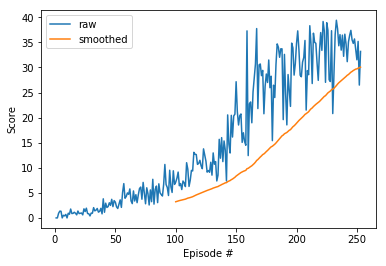

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
n_scores = len(scores)
plt.plot(np.arange(1, n_scores+1), scores, label="raw")
if len(scores)>=100:
    plt.plot(
        np.arange(100, n_scores+1),
        [np.mean(scores[i-100:i]) for i in range(100, n_scores+1)],
        label="smoothed",
    )
plt.plot()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2,)
agent.load('checkpoint_actor.pth', 'checkpoint_critic.pth')

random_action = True

while True:
    if random_action:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    else:
        actions = agent.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 34.64999922551215
